# GBDT Training Code Testbed

This notebook will conduct code prototyping for executing GBDT training related processes.

In [1]:
#Python Libraries
import time

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt
from sklearn.model_selection import LearningCurveDisplay

#GBDT Models
import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

#Timer
start = end = 0
def startTime():
    global start
    start = time.time()
def endTime():
    global start
    elapse = time.time()-start
    start = 0
    print(f"Elapsed Time: {round(elapse, 6)}s\n")
    return round(elapse, 6)

#File paths
TB = "../Dataset/TB/TB.csv"
TB_Reserve = "../Dataset/TB/TB_Reserve.csv"
TB_Enc = "../Dataset/TB/TB_Enc.csv"
TB_Reserve_Enc = "../Dataset/TB/TB_Reserve_Enc.csv"
IB = "../Dataset/IB/IB.csv"
IB_Reserve = "../Dataset/IB/IB_Reserve.csv"
IB_Enc = "../Dataset/IB/IB_Enc.csv"
IB_Reserve_Enc = "../Dataset/IB/IB_Reserve_Enc.csv" 

#N_Split
SPLIT = 5

In [2]:
#DATASET PARSING

tb = pd.read_csv(TB, low_memory=False, dtype='string')
tb_res = pd.read_csv(TB_Reserve, low_memory=False, dtype='string')
tb_enc = pd.read_csv(TB_Enc, low_memory=False)
tb_res_enc = pd.read_csv(TB_Reserve_Enc, low_memory=False)

ib = pd.read_csv(IB, low_memory=False, dtype='string')
ib_res = pd.read_csv(IB_Reserve, low_memory=False, dtype='string')
ib_enc = pd.read_csv(IB_Enc, low_memory=False)
ib_res_enc = pd.read_csv(IB_Reserve_Enc, low_memory=False)

In [3]:
#AUXILIARY FUNCTIONS

#Separate the features (X) & labels (y)
def getXy(dataset):
    return dataset.iloc[:,1:],dataset.iloc[:,0]

#Generate StratifiedKFold object at given splits
def getStratKFold(splits):
    #It might be shuffled but it does so consistently (i.e., random_state=1)
    return StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)

#Internal K-Folds Test (for in-training testing)
def kfolds_test(X,y,model):
    print("Internal KFolds Test")
    sublist = [["accuracy", "f1_score","precision","recall","roc-auc","time(s)"]]
    axis = 0
    for i, (train_index, test_index) in enumerate(getStratKFold(SPLIT).split(X,y)):
        start = time.time()
        test_set = np.take(X, test_index, axis)
        test_set_labels = np.take(y, test_index, axis)
        m_pred = model.predict(test_set)
        sublist.append([
                        round(accuracy_score(test_set_labels, m_pred),4),
                        round(f1_score(test_set_labels, m_pred, average='weighted'),4),
                        round(precision_score(test_set_labels, m_pred,zero_division=0),4),
                        round(recall_score(test_set_labels, m_pred),4),
                        round(roc_auc_score(test_set_labels, m_pred),4),
                        round(time.time()-start,4)
                        ])
    for s in sublist:
        print(s)
    print("")

#Learning Curves
def learning_curve(dataset,model):
    X,y = getXy(dataset)
    vis_param = {
    "X": X, "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 20),
    "cv": getStratKFold(SPLIT),
    "score_type": "both", "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
    }
    display = LearningCurveDisplay.from_estimator(model, **vis_param)
    plt.show()
    
#K-folds sample visualization
def kfolds_vis(dataset):
    X,y = getXy(dataset)
    fig, ax = plt.subplots()
    display = plot_cv_indices(getStratKFold(SPLIT), X, y, ax, SPLIT)
    plt.show()

#K-folds sample visualization (inner workings)
def plot_cv_indices(cv, X, y, ax, n_splits, lw=25):
    #From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        ax.scatter(range(len(indices)), [ii] * len(indices), c=indices, marker="_", 
                   lw=lw, cmap=plt.cm.Paired, vmin=0, vmax=1)
    #ax.scatter(range(len(X)), [ii] * len(X), c=y, marker="_", lw=lw, cmap=plt.cm.Paired)
    
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits), yticklabels=yticklabels, xlabel="Dataset Subsample", ylabel="CV iteration", ylim=[n_splits,-0.5], xlim=[0, X.shape[0]])
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

Stratified K-Folds Split at 5 splits.
TB/TB Encoded Dataset


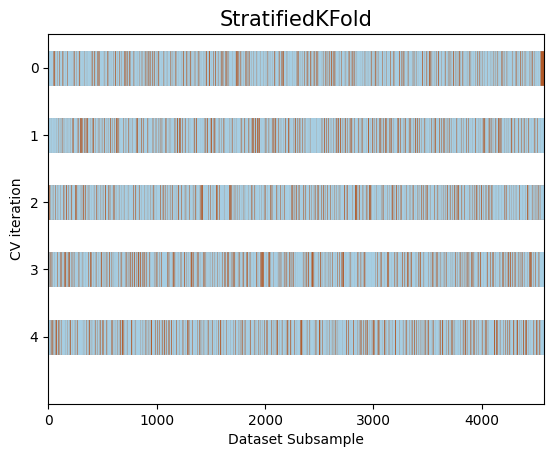

IB/IB Encoded Dataset


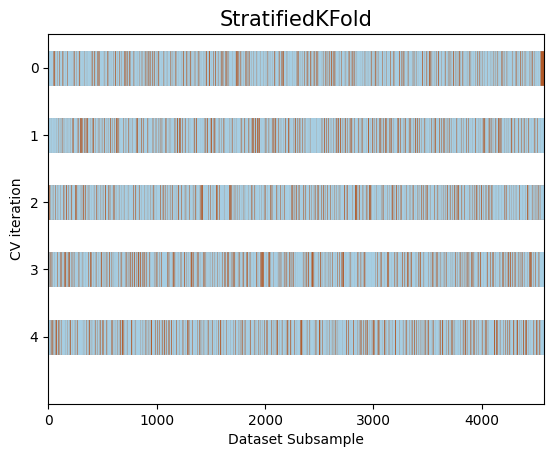

In [4]:
print("Stratified K-Folds Split at",SPLIT,"splits.")
print("TB/TB Encoded Dataset")
kfolds_vis(tb_enc)
print("IB/IB Encoded Dataset")
kfolds_vis(ib_enc)

# 1. Preparing Training Functions

In [5]:
#Model training; Shows a simple k-folds test
def train_model(model, dataset, title): #model assumes to be either trained/fitted or not
    X,y = getXy(dataset) #Get features(X) and labels(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1, shuffle=True)#Splitting data into train (70%) and test (30%) 
    print("Training", title, "...")
    start = time.time()
    model.fit(X_train, y_train) #Training
    print(f"{title} Training Time: {time.time()-start:.4f}s")
    print(title, "Trained!")
    print("Internal Classification Report:\n", classification_report(y_test, model.predict(X_test),digits=4))
    kfolds_test(X, y, model) #Check current capabilities using entirety of Train Split ("Training"+"Validation"; i.e., mix of know and unknown)
    return model

def tune_model(model, params, dataset, title):
    X,y = getXy(dataset) #Get features(X) and labels(y)
    print("Tuning", title, "...")
    #Example shown uses RandomizedSearchCV
    tuner = RandomizedSearchCV(model, params, n_iter=10, scoring=None, n_jobs=1, 
                               refit=True, cv=getStratKFold(SPLIT), verbose=0, pre_dispatch='2*n_jobs', random_state=1, 
                               error_score=0, return_train_score=False)
    start = time.time()
    tuner.fit(X,y) #Utilizing Train Split (i.e., both "Training"+"Validation") for tuning as it uses its own CV method
    print(f"{title} Tuning Time: {time.time()-start:.4f}s")
    print(title, "Tuned!")
    print(title, "Best Params:", tuner.best_params_)
    return tuner.best_params_

def saveLGBM(model, filename):
    if ".joblib" not in filename:
        filename += ".joblib"
    dump(model, filename)
    print("LGBM Model", filename, "saved!")

def saveCatB(model, filename):
    if ".json" not in filename:
        filename += ".json"
    model.save_model(filename, format="json")
    print("CatBoost Model", filename, "saved!")

def lbgm_train_tune(dataset, title, lgbm_params):
    #Default
    lgbm_classifier = lightgbm.LGBMClassifier(random_state=1, n_jobs=-1, verbose=-1)
    lgbm_default = train_model(lgbm_classifier, dataset, title+"_Default")
    saveLGBM(lgbm_default, title+"_Default.joblib")
    #Tuning
    lgbm_params = tune_model(lgbm_classifier, lgbm_params, dataset, title+"_Tuned")
    #Tuned
    lgbm_classifier = lightgbm.LGBMClassifier(**lgbm_params, random_state=1, n_jobs=-1, verbose=-1)
    lgbm_tuned = train_model(lgbm_classifier, dataset, title+"_Tuned")
    saveLGBM(lgbm_tuned, title+"_Tuned.joblib")
    return lgbm_default, lgbm_tuned
    
def catb_train_tune(dataset, title, catb_params):
    indexes = []
    for i in range(dataset.shape[1]-1):
        indexes.append(i)
    #Default
    catb_classifier = catboost.CatBoostClassifier(random_state=1, thread_count=-1, verbose=0, cat_features=indexes)
    catboost_default = train_model(catb_classifier, dataset, title+"_Default")
    saveCatB(catboost_default, title+"_Default.json")
    #Tuning
    catb_params = tune_model(catb_classifier, catb_params, dataset, title+"_Tuned")
    #Tuned
    catb_classifier = catboost.CatBoostClassifier(**catb_params, random_state=1, n_jobs=-1, verbose=0, cat_features=indexes)
    catboost_tuned = train_model(catb_classifier, dataset, title+"_Tuned")
    saveCatB(catboost_tuned, title+"_Tuned.json")
    return catboost_default, catboost_tuned

# 2. LightGBM Models

In [6]:
#Sample parameter set
lgbm_params = {
    'boosting_type':['gbdt', 'rf'], 
    'num_leaves':[31,None], 
    'max_depth':[-1], 
    'learning_rate':[0.1], 
    'n_estimators':[100,250,500,750,1000,None], 
    'objective':['binary'], 
    'class_weight': [None,'balanced'],
    'importance_type':['split','gain'],
    'data_sample_strategy':['bagging','goss'],
    'subsample':[0.25,0.5,0.75,1],
    'tree_learner':['voting'],
    'device':['cpu'], #can add/change to GPU if supported
    'extra_trees':[True,False]
}

In [7]:
#Time-based LGBM
default, tuned = lbgm_train_tune(tb_enc, "TB_LGBM", lgbm_params)

tb_tuned_param = tuned.get_params()

Training TB_LGBM_Default ...
TB_LGBM_Default Training Time: 0.3427s
TB_LGBM_Default Trained!
Internal Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9814    0.9906       699
           1     0.9811    1.0000    0.9904       674

    accuracy                         0.9905      1373
   macro avg     0.9905    0.9907    0.9905      1373
weighted avg     0.9907    0.9905    0.9905      1373

Internal KFolds Test
['accuracy', 'f1_score', 'precision', 'recall', 'roc-auc', 'time(s)']
[0.9956, 0.9956, 0.9913, 1.0, 0.9956, 0.027]
[0.9989, 0.9989, 0.9978, 1.0, 0.9989, 0.024]
[0.9989, 0.9989, 0.9978, 1.0, 0.9989, 0.0245]
[0.9967, 0.9967, 0.9935, 1.0, 0.9967, 0.023]
[0.9956, 0.9956, 0.9913, 1.0, 0.9956, 0.024]

LGBM Model TB_LGBM_Default.joblib saved!
Tuning TB_LGBM_Tuned ...


C:\Users\ejose\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ejose\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ejose\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "C:\Users\ejose\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\ejose\anaconda3\Lib\site-packages\lightgbm\en

TB_LGBM_Tuned Tuning Time: 217.1665s
TB_LGBM_Tuned Tuned!
TB_LGBM_Tuned Best Params: {'tree_learner': 'voting', 'subsample': 1, 'objective': 'binary', 'num_leaves': None, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.1, 'importance_type': 'gain', 'device': 'cpu', 'data_sample_strategy': 'bagging', 'class_weight': None, 'boosting_type': 'gbdt'}
Training TB_LGBM_Tuned ...
TB_LGBM_Tuned Training Time: 0.5912s
TB_LGBM_Tuned Trained!
Internal Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9814    0.9906       699
           1     0.9811    1.0000    0.9904       674

    accuracy                         0.9905      1373
   macro avg     0.9905    0.9907    0.9905      1373
weighted avg     0.9907    0.9905    0.9905      1373

Internal KFolds Test
['accuracy', 'f1_score', 'precision', 'recall', 'roc-auc', 'time(s)']
[0.9956, 0.9956, 0.9913, 1.0, 0.9956, 0.028]
[0.9989, 0.9989, 0.9978, 1.0, 0.9989, 0.028]
[0.9989, 0.9989

In [8]:
#Instance-based LGBM
default, tuned = lbgm_train_tune(ib_enc, "IB_LGBM", lgbm_params)

ib_tuned_param = tuned.get_params()

Training IB_LGBM_Default ...
IB_LGBM_Default Training Time: 0.4036s
IB_LGBM_Default Trained!
Internal Classification Report:
               precision    recall  f1-score   support

           0     0.9956    0.9785    0.9870       699
           1     0.9781    0.9955    0.9868       674

    accuracy                         0.9869      1373
   macro avg     0.9869    0.9870    0.9869      1373
weighted avg     0.9870    0.9869    0.9869      1373

Internal KFolds Test
['accuracy', 'f1_score', 'precision', 'recall', 'roc-auc', 'time(s)']
[0.9956, 0.9956, 0.9913, 1.0, 0.9956, 0.0235]
[0.9967, 0.9967, 0.9978, 0.9956, 0.9967, 0.022]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.024]
[0.9945, 0.9945, 0.9913, 0.9978, 0.9945, 0.023]
[0.9934, 0.9934, 0.987, 1.0, 0.9934, 0.0235]

LGBM Model IB_LGBM_Default.joblib saved!
Tuning IB_LGBM_Tuned ...


C:\Users\ejose\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ejose\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ejose\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "C:\Users\ejose\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\ejose\anaconda3\Lib\site-packages\lightgbm\en

IB_LGBM_Tuned Tuning Time: 225.1131s
IB_LGBM_Tuned Tuned!
IB_LGBM_Tuned Best Params: {'tree_learner': 'voting', 'subsample': 0.25, 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.1, 'importance_type': 'gain', 'device': 'cpu', 'data_sample_strategy': 'bagging', 'class_weight': 'balanced', 'boosting_type': 'gbdt'}
Training IB_LGBM_Tuned ...
IB_LGBM_Tuned Training Time: 0.5661s
IB_LGBM_Tuned Trained!
Internal Classification Report:
               precision    recall  f1-score   support

           0     0.9956    0.9800    0.9877       699
           1     0.9796    0.9955    0.9875       674

    accuracy                         0.9876      1373
   macro avg     0.9876    0.9878    0.9876      1373
weighted avg     0.9877    0.9876    0.9876      1373

Internal KFolds Test
['accuracy', 'f1_score', 'precision', 'recall', 'roc-auc', 'time(s)']
[0.9945, 0.9945, 0.9913, 0.9978, 0.9945, 0.023]
[0.9978, 0.9978, 0.9978, 0.9978, 0.9978, 0.022]
[1

LGBM TB Dataset (Tuned)


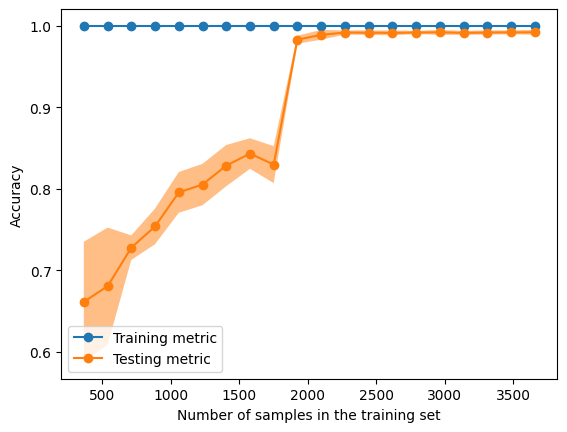

LGBM IB Dataset (Tuned)


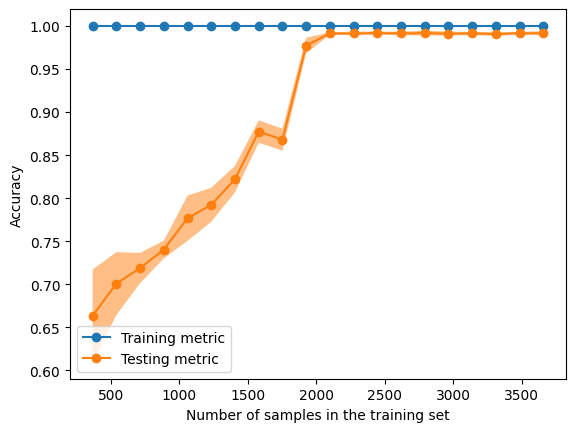

In [9]:
#Check model learning scalability and variability using various sizes of TB dataset
print("LGBM TB Dataset (Tuned)")
learning_curve(tb_enc,lightgbm.LGBMClassifier(**tb_tuned_param))

#Check model learning scalability and variability using various sizes of IB dataset
print("LGBM IB Dataset (Tuned)")
learning_curve(ib_enc,lightgbm.LGBMClassifier(**ib_tuned_param))

# 3. CatBoost Models

In [10]:
#Sample parameter set
catb_params = {
    'n_estimators':[100,500,1000,5000],
    'learning_rate':[0.1],
    'max_depth':[6,8,16],
    'num_leaves':[31, None],
    'subsample':[0.5,1],
    'grow_policy':['SymmetricTree', 'Depthwise'],
    'boosting_type':['Ordered', 'Plain'],
}

In [ ]:
#Time-based CatBoost
default, tuned = catb_train_tune(tb, "TB_CATB", catb_params)

tb_tuned_param = tuned.get_param()

Training TB_CATB_Default ...


In [ ]:
#Instance-based CatBoost
default, tuned = catb_train_tune(ib, "IB_CATB", catb_params)

ib_tuned_param = tuned.get_param()

In [ ]:
#Check model learning scalability and variability using various sizes of TB dataset
print("TB Dataset (Tuned)")
learning_curve(tb_enc,catboost.CatBoostClassifier(**tb_tuned_param))

#Check model learning scalability and variability using various sizes of IB dataset
print("IB Dataset (Tuned)")
learning_curve(ib_enc,catboost.CatBoostClassifier(**ib_tuned_param))